In [1]:
import os
import tensorflow as tf
import numpy as np
from keras.applications import ResNet50
from efficientnet.tfkeras import EfficientNetB4
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score
import seaborn as sns
from IPython.display import Image
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
train_path = "./wildfire-dataset/train"
valid_path = "./wildfire-dataset/valid"
test_path = "./wildfire-dataset/test"

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(350, 350),
    batch_size=32,
    class_mode='binary',
    shuffle=True)

valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(350, 350),
    batch_size=32,
    class_mode='binary',
    shuffle=True)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(350, 350),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.


In [5]:
def display_images_from_generator(generator, num_images=5):
    x_batch, y_batch = next(generator)

    plt.figure(figsize=(num_images * 3, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(x_batch[i])
        label = "1: wildfire" if y_batch[i] > 0.5 else "0: nowildfire"
        plt.title(label, fontsize=12)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

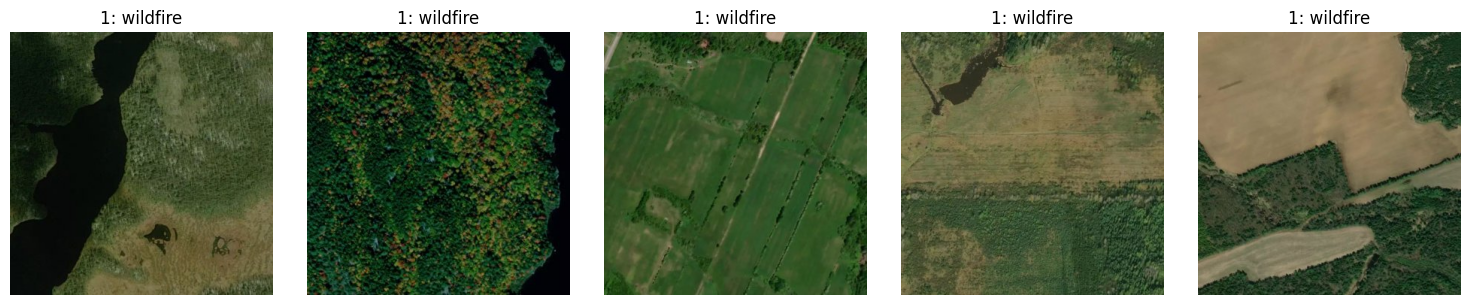

In [6]:
display_images_from_generator(train_generator)

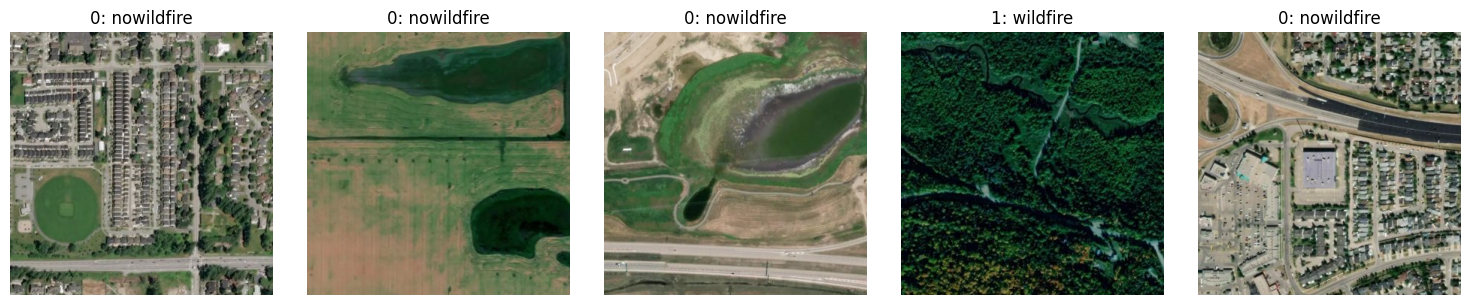

In [7]:
display_images_from_generator(valid_generator)

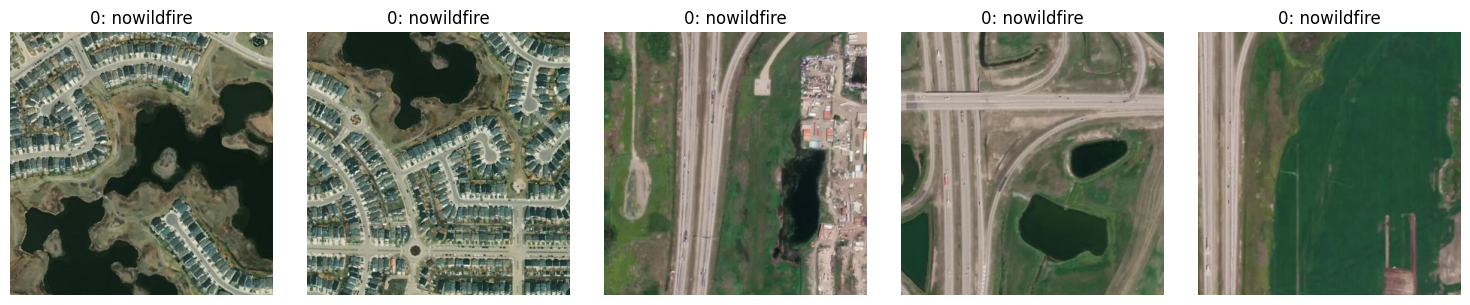

In [8]:
display_images_from_generator(test_generator)

In [9]:
def cnn_model(input_shape=(350, 350, 3), weight_decay=0.001):
    inputs = Input(shape=input_shape, name='input_layer')
    x = Conv2D(32, (3, 3), activation='relu', name='conv2d_layer1')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs, name='traditional-cnn')
    model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [10]:
model=cnn_model()

In [11]:
model.summary()

Model: "traditional-cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 350, 350, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer1 (Conv2D)          │ (None, 348, 348, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 348, 348, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 174, 174, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 172, 172, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 172, 172, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 86, 86, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 84, 84, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 84, 84, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 42, 42, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 40, 40, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 20, 20, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 102400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    52,429,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,820,161 (201.49 MB)

 Trainable params: 52,819,201 (201.49 MB)

 Non-trainable params: 960 (3.75 KB)

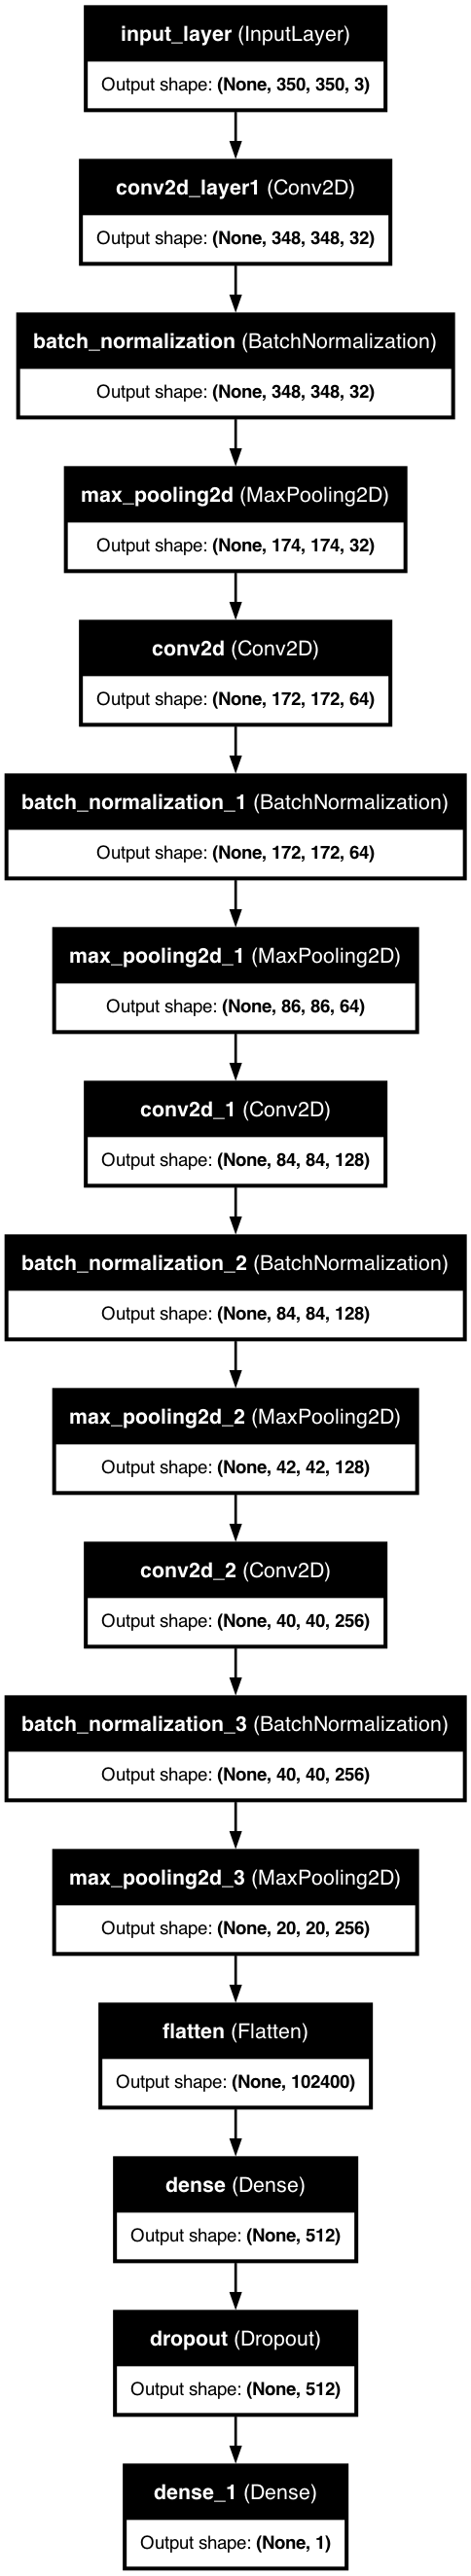

In [12]:
plot_model(model, to_file=f'{model.name}_model.png', show_shapes=True, show_layer_names=True, expand_nested=True, dpi=96)
Image(filename=f'{model.name}_model.png')

In [13]:
%%time
checkpointer = ModelCheckpoint(f'{model.name}.weights.h5', verbose=1, save_best_only=True, save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
    train_generator,
    epochs=10,
    verbose=1,
    validation_data=valid_generator,
    callbacks=[checkpointer, early_stopping]
)

Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 0s 852ms/step - accuracy: 0.8741 - loss: 11.0088
Epoch 1: val_loss improved from inf to 1.26682, saving model to traditional-cnn.weights.h5
946/946 ━━━━━━━━━━━━━━━━━━━━ 846s 893ms/step - accuracy: 0.8742 - loss: 11.0032 - val_accuracy: 0.9397 - val_loss: 1.2668
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - accuracy: 0.9106 - loss: 1.3081
Epoch 2: val_loss improved from 1.26682 to 0.36242, saving model to traditional-cnn.weights.h5
946/946 ━━━━━━━━━━━━━━━━━━━━ 895s 946ms/step - accuracy: 0.9106 - loss: 1.3078 - val_accuracy: 0.9454 - val_loss: 0.3624
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.9270 - loss: 0.4383
Epoch 3: val_loss did not improve from 0.36242
946/946 ━━━━━━━━━━━━━━━━━━━━ 915s 967ms/step - accuracy: 0.9270 - loss: 0.4383 - val_accuracy: 0.9151 - val_loss: 0.4674
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 0s 919ms/step - accuracy: 0.9255 - loss: 0.5784
Epoch 4: val_loss did not improve from 0.36242
946

In [14]:
def display_images_with_predictions_from_generator(generator, model, num_wildfire=2, num_nowildfire=2):
    wildfire_pool = []
    nowildfire_pool = []

    while len(wildfire_pool) < num_wildfire or len(nowildfire_pool) < num_nowildfire:
        x_batch, y_batch = next(generator)
        for i in range(len(y_batch)):
            if y_batch[i] > 0.5:  # Wildfire
                wildfire_pool.append((x_batch[i], y_batch[i]))
            else:  # No Wildfire
                nowildfire_pool.append((x_batch[i], y_batch[i]))

    np.random.seed(10)
    selected_wildfire = np.random.choice(range(len(wildfire_pool)), size=num_wildfire, replace=False)
    selected_nowildfire = np.random.choice(range(len(nowildfire_pool)), size=num_nowildfire, replace=False)

    selected_images = [wildfire_pool[i][0] for i in selected_wildfire] + [nowildfire_pool[i][0] for i in selected_nowildfire]
    selected_labels = [wildfire_pool[i][1] for i in selected_wildfire] + [nowildfire_pool[i][1] for i in selected_nowildfire]

    predictions = model.predict(np.array(selected_images)).flatten()

    plt.figure(figsize=(len(selected_images) * 3, 3))
    for i in range(len(selected_images)):
        plt.subplot(1, len(selected_images), i + 1)
        plt.imshow(selected_images[i])
        true_label = "Wildfire" if selected_labels[i] > 0.5 else "No Wildfire"
        predicted_label = "Wildfire" if predictions[i] > 0.5 else "No Wildfire"
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


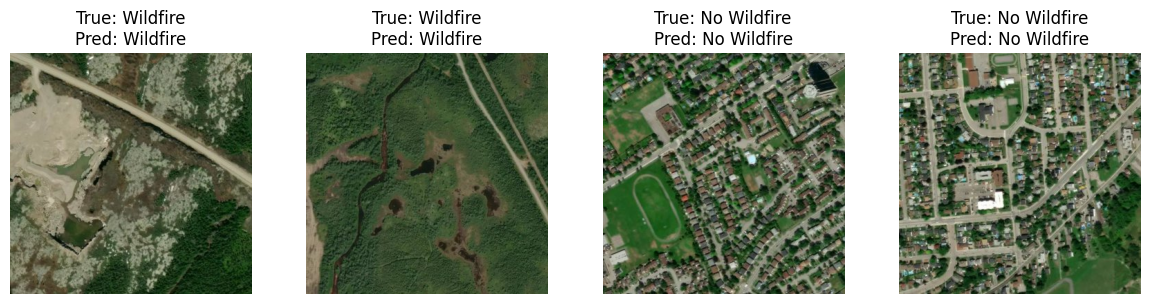

In [15]:
display_images_with_predictions_from_generator(test_generator, model)

In [16]:
def plot_confusion_matrix_and_metrics(generator, model):
    label_names = ['No Wildfire', 'Wildfire']
    # Step 1: Calculate metrics and prepare the data
    y_true = generator.classes
    y_pred = model.predict(generator)
    y_pred = (y_pred > 0.5).astype(int)
    
    # Confusion matrix visualization
    conf_mat = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(ticks=np.arange(len(label_names)) + 0.5, labels=label_names, rotation=45)
    plt.yticks(ticks=np.arange(len(label_names)) + 0.5, labels=label_names, rotation=45)
    plt.show()

    # Classification Report in text
    report_text = classification_report(y_true, y_pred, target_names=label_names)
    print(report_text)
    
    # Print F1 score
    f1 = f1_score(y_true, y_pred)
    print(f"F1 Score: {f1:.2f}")

    # Print accuracy in percentage
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")

197/197 ━━━━━━━━━━━━━━━━━━━━ 37s 189ms/step


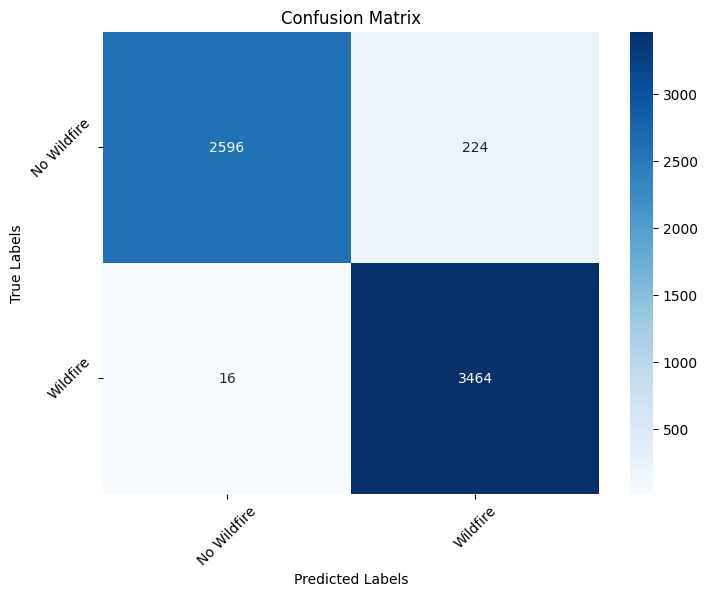

              precision    recall  f1-score   support

 No Wildfire       0.99      0.92      0.96      2820
    Wildfire       0.94      1.00      0.97      3480

    accuracy                           0.96      6300
   macro avg       0.97      0.96      0.96      6300
weighted avg       0.96      0.96      0.96      6300

F1 Score: 0.97
Accuracy: 96.19%


In [17]:
plot_confusion_matrix_and_metrics(test_generator, model)

In [18]:
def plot_training_history(history):
    plt.figure(figsize=(16, 6))

    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Model Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Train Loss', marker='o')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Model Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{model.name}_training_history.png', dpi=300)
    plt.show()

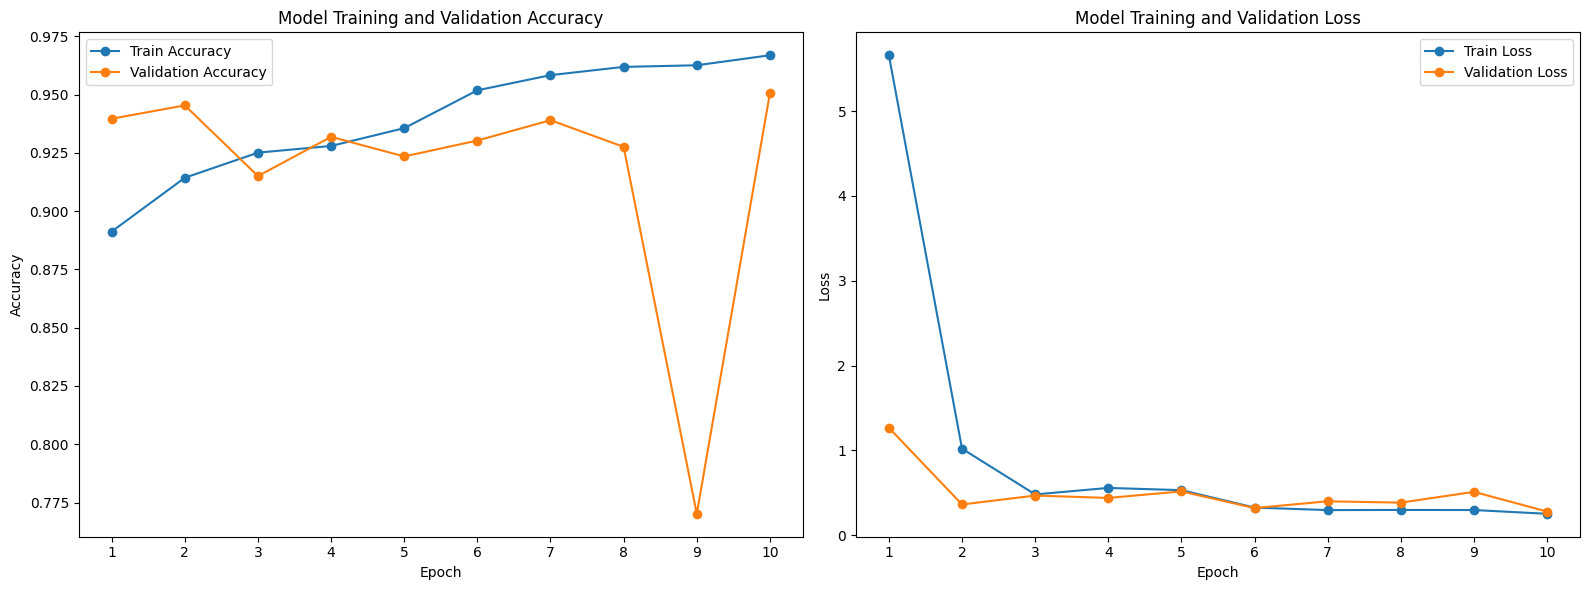

In [19]:
plot_training_history(history)